# Merging pokemons

In this tutorial we will create an autoencoder to merge different pokemons into new ones.

## Idea

This idea came from a famous website that allow you to merge pokemons called "Pokemon Fusion". Link [here](https://pokemon.alexonsager.net/)

I am not sure how the website system does it, but the idea itself sounded good for a tutorial about autoencoders.

## Autoencoders

So, to start, lets talk about what are autoencoders.
They are a type of machine learning algorithms where we aim to reconstruct the original data through a more compact representaiton of it. 

We can achieve it by using the original input as output to calculate the error. With this our loss function is the MSE (minimun square error) of the output image and the original image.

### Autoencoders with neural network

When talking about neural networds we want a network that gets progressively small then goes back to the same size. with the layer in the middle representing our code for the input, the left part being our encoder and the right part being our decoder. 
We want this sideways hourglass shape because if we were to create a code that is bigger than the input, it would be easier to just send the input.

Here we have an image representing the common archtecture for neural networks autoencoders:
![autoencoders archtecture](https://cdn-images-1.medium.com/max/1574/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

## What you will need

For this tutorials we are going to need:
- python 3.4
- Tensorflow
- Keras with tensorflow backend
- numpy (as always)
- sklearn (for making our lifes easier when splitting the datasets)
- scipy (for loading the images)
- matplotlib

The dataset we will use is a collection of sprites from all 800+ pokemons.
This can be downloaded on kaggle through this link: [Pokemon Image dataset](https://www.kaggle.com/kvpratama/pokemon-images-dataset)

In [1]:
import sys
import os
import tensorflow as tf
import keras, keras.layers as Layers, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import transform
from scipy import misc
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


---
# Getting our hands dirty

## Loading the data

Lets start by loading and visualizing the dataset.
Assume that we extracted the zip file into the folder data/

In [2]:
img_addresses = os.listdir("data/")
dataset = []
for img_address in img_addresses:
    img = misc.imread("data/"+img_address)
    img = img[:,:,0:3] / 255 - 0.5 #normalizing
    img = transform.resize(img, (32, 32))
    #img = (img - np.mean(img))/np.std(img) #brigning the mean around 0.0  and the standard deviation around 1.0
    dataset.append(img)
dataset = np.array(dataset)

/usr/lib64/python3.4/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [3]:
def show_image(x):
    plt.imshow(np.clip(x+0.5, 0, 1))

Image shape: (32, 32, 3)
Image mean: -0.0
Image std: 0.300038075965566


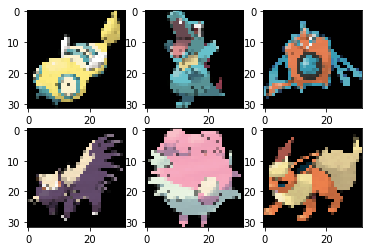

In [4]:
IMG_SIZE = dataset[0].shape
print("Image shape: {}".format(IMG_SIZE))
print("Image mean: {}".format(np.round(np.mean(dataset[0]))))
print("Image std: {}".format(np.std(dataset[0])))
for i in range(6):
    idx = np.random.randint(0,high=(len(dataset)),size=1)[0]
    plt.subplot(2,3,i+1)
    show_image(dataset[idx][:,:,:])

In [5]:
# now lets split our data into training and test
X_train, X_test = train_test_split(dataset, test_size=0.1, random_state=42)

You probably noticed that we removed one channel from the images. That is because there was a transperency channel(also called alpha) that we are ignoring for  this tutorial.

#### Note, adding a class for progress bar

Got this class from the advanced machine learning course on Coursera. It is for showing a cool looking progress bar when training with keras. If you got curious about the course check them out at [Coursera - advanded machine learning](https://www.coursera.org/specializations/aml)

In [6]:
import tqdm
from collections import defaultdict
import numpy as np
from keras.models import save_model


class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('Epoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm.tqdm_notebook(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


### For starters: simple autoencoder

To begin our journey, we will use keras to make a simple 2 layered fully connected auto encoder.

In [7]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [8]:
def simple_autoencoder(img_shape, code_size):
    
    encoder = keras.models.Sequential()
    encoder.add(Layers.InputLayer(img_shape))
    encoder.add(Layers.Flatten())                  #flattening the image image into a vector
    encoder.add(Layers.Dense(2046, activation='elu'))
    encoder.add(Layers.Dense(1024, activation='elu'))
    encoder.add(Layers.Dense(512, activation='elu'))
    encoder.add(Layers.Dense(256, activation='elu'))
    encoder.add(Layers.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(Layers.InputLayer((code_size,)))
    decoder.add(Layers.Dense(256, activation='elu'))
    decoder.add(Layers.Dense(512, activation='elu'))
    decoder.add(Layers.Dense(1024, activation='elu'))  
    decoder.add(Layers.Dense(2046, activation='elu'))  
    decoder.add(Layers.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(Layers.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [29]:
sess = reset_tf_session() #reseting the session, just in case
encoder,decoder = simple_autoencoder(IMG_SIZE, code_size=64)

input_l = Layers.Input(IMG_SIZE)
code = encoder(input_l)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=input_l, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=200,
                validation_data=[X_test, X_test],
                callbacks=[TqdmProgressCallback()],
                verbose=0)

Epoch 1/200


A Jupyter Widget


Epoch 2/200


A Jupyter Widget


Epoch 3/200


A Jupyter Widget


Epoch 4/200


A Jupyter Widget


Epoch 5/200


A Jupyter Widget


Epoch 6/200


A Jupyter Widget


Epoch 7/200


A Jupyter Widget


Epoch 8/200


A Jupyter Widget


Epoch 9/200


A Jupyter Widget


Epoch 10/200


A Jupyter Widget


Epoch 11/200


A Jupyter Widget


Epoch 12/200


A Jupyter Widget


Epoch 13/200


A Jupyter Widget


Epoch 14/200


A Jupyter Widget


Epoch 15/200


A Jupyter Widget


Epoch 16/200


A Jupyter Widget


Epoch 17/200


A Jupyter Widget


Epoch 18/200


A Jupyter Widget


Epoch 19/200


A Jupyter Widget


Epoch 20/200


A Jupyter Widget


Epoch 21/200


A Jupyter Widget


Epoch 22/200


A Jupyter Widget


Epoch 23/200


A Jupyter Widget


Epoch 24/200


A Jupyter Widget


Epoch 25/200


A Jupyter Widget


Epoch 26/200


A Jupyter Widget


Epoch 27/200


A Jupyter Widget


Epoch 28/200


A Jupyter Widget


Epoch 29/200


A Jupyter Widget


Epoch 30/200


A Jupyter Widget


Epoch 31/200


A Jupyter Widget


Epoch 32/200


A Jupyter Widget


Epoch 33/200


A Jupyter Widget


Epoch 34/200


A Jupyter Widget


Epoch 35/200


A Jupyter Widget


Epoch 36/200


A Jupyter Widget


Epoch 37/200


A Jupyter Widget


Epoch 38/200


A Jupyter Widget


Epoch 39/200


A Jupyter Widget


Epoch 40/200


A Jupyter Widget


Epoch 41/200


A Jupyter Widget


Epoch 42/200


A Jupyter Widget


Epoch 43/200


A Jupyter Widget


Epoch 44/200


A Jupyter Widget


Epoch 45/200


A Jupyter Widget


Epoch 46/200


A Jupyter Widget


Epoch 47/200


A Jupyter Widget


Epoch 48/200


A Jupyter Widget


Epoch 49/200


A Jupyter Widget


Epoch 50/200


A Jupyter Widget


Epoch 51/200


A Jupyter Widget


Epoch 52/200


A Jupyter Widget


Epoch 53/200


A Jupyter Widget


Epoch 54/200


A Jupyter Widget


Epoch 55/200


A Jupyter Widget


Epoch 56/200


A Jupyter Widget


Epoch 57/200


A Jupyter Widget


Epoch 58/200


A Jupyter Widget


Epoch 59/200


A Jupyter Widget


Epoch 60/200


A Jupyter Widget


Epoch 61/200


A Jupyter Widget


Epoch 62/200


A Jupyter Widget


Epoch 63/200


A Jupyter Widget


Epoch 64/200


A Jupyter Widget


Epoch 65/200


A Jupyter Widget


Epoch 66/200


A Jupyter Widget


Epoch 67/200


A Jupyter Widget


Epoch 68/200


A Jupyter Widget


Epoch 69/200


A Jupyter Widget


Epoch 70/200


A Jupyter Widget


Epoch 71/200


A Jupyter Widget


Epoch 72/200


A Jupyter Widget


Epoch 73/200


A Jupyter Widget


Epoch 74/200


A Jupyter Widget


Epoch 75/200


A Jupyter Widget


Epoch 76/200


A Jupyter Widget


Epoch 77/200


A Jupyter Widget


Epoch 78/200


A Jupyter Widget


Epoch 79/200


A Jupyter Widget


Epoch 80/200


A Jupyter Widget


Epoch 81/200


A Jupyter Widget


Epoch 82/200


A Jupyter Widget


Epoch 83/200


A Jupyter Widget


Epoch 84/200


A Jupyter Widget


Epoch 85/200


A Jupyter Widget


Epoch 86/200


A Jupyter Widget


Epoch 87/200


A Jupyter Widget


Epoch 88/200


A Jupyter Widget


Epoch 89/200


A Jupyter Widget


Epoch 90/200


A Jupyter Widget


Epoch 91/200


A Jupyter Widget


Epoch 92/200


A Jupyter Widget


Epoch 93/200


A Jupyter Widget


Epoch 94/200


A Jupyter Widget


Epoch 95/200


A Jupyter Widget


Epoch 96/200


A Jupyter Widget


Epoch 97/200


A Jupyter Widget


Epoch 98/200


A Jupyter Widget


Epoch 99/200


A Jupyter Widget


Epoch 100/200


A Jupyter Widget


Epoch 101/200


A Jupyter Widget


Epoch 102/200


A Jupyter Widget


Epoch 103/200


A Jupyter Widget


Epoch 104/200


A Jupyter Widget


Epoch 105/200


A Jupyter Widget


Epoch 106/200


A Jupyter Widget


Epoch 107/200


A Jupyter Widget


Epoch 108/200


A Jupyter Widget


Epoch 109/200


A Jupyter Widget


Epoch 110/200


A Jupyter Widget


Epoch 111/200


A Jupyter Widget


Epoch 112/200


A Jupyter Widget


Epoch 113/200


A Jupyter Widget


Epoch 114/200


A Jupyter Widget


Epoch 115/200


A Jupyter Widget


Epoch 116/200


A Jupyter Widget


Epoch 117/200


A Jupyter Widget


Epoch 118/200


A Jupyter Widget


Epoch 119/200


A Jupyter Widget


Epoch 120/200


A Jupyter Widget


Epoch 121/200


A Jupyter Widget


Epoch 122/200


A Jupyter Widget


Epoch 123/200


A Jupyter Widget


Epoch 124/200


A Jupyter Widget


Epoch 125/200


A Jupyter Widget


Epoch 126/200


A Jupyter Widget


Epoch 127/200


A Jupyter Widget


Epoch 128/200


A Jupyter Widget


Epoch 129/200


A Jupyter Widget


Epoch 130/200


A Jupyter Widget


Epoch 131/200


A Jupyter Widget


Epoch 132/200


A Jupyter Widget


Epoch 133/200


A Jupyter Widget


Epoch 134/200


A Jupyter Widget


Epoch 135/200


A Jupyter Widget


Epoch 136/200


A Jupyter Widget


Epoch 137/200


A Jupyter Widget


Epoch 138/200


A Jupyter Widget


Epoch 139/200


A Jupyter Widget


Epoch 140/200


A Jupyter Widget


Epoch 141/200


A Jupyter Widget


Epoch 142/200


A Jupyter Widget


Epoch 143/200


A Jupyter Widget


Epoch 144/200


A Jupyter Widget


Epoch 145/200


A Jupyter Widget


Epoch 146/200


A Jupyter Widget


Epoch 147/200


A Jupyter Widget


Epoch 148/200


A Jupyter Widget


Epoch 149/200


A Jupyter Widget


Epoch 150/200


A Jupyter Widget


Epoch 151/200


A Jupyter Widget


Epoch 152/200


A Jupyter Widget


Epoch 153/200


A Jupyter Widget


Epoch 154/200


A Jupyter Widget


Epoch 155/200


A Jupyter Widget


Epoch 156/200


A Jupyter Widget


Epoch 157/200


A Jupyter Widget


Epoch 158/200


A Jupyter Widget


Epoch 159/200


A Jupyter Widget


Epoch 160/200


A Jupyter Widget


Epoch 161/200


A Jupyter Widget


Epoch 162/200


A Jupyter Widget


Epoch 163/200


A Jupyter Widget


Epoch 164/200


A Jupyter Widget


Epoch 165/200


A Jupyter Widget


Epoch 166/200


A Jupyter Widget


Epoch 167/200


A Jupyter Widget


Epoch 168/200


A Jupyter Widget


Epoch 169/200


A Jupyter Widget


Epoch 170/200


A Jupyter Widget


Epoch 171/200


A Jupyter Widget


Epoch 172/200


A Jupyter Widget


Epoch 173/200


A Jupyter Widget


Epoch 174/200


A Jupyter Widget


Epoch 175/200


A Jupyter Widget


Epoch 176/200


A Jupyter Widget


Epoch 177/200


A Jupyter Widget


Epoch 178/200


A Jupyter Widget


Epoch 179/200


A Jupyter Widget


Epoch 180/200


A Jupyter Widget


Epoch 181/200


A Jupyter Widget


Epoch 182/200


A Jupyter Widget


Epoch 183/200


A Jupyter Widget


Epoch 184/200


A Jupyter Widget


Epoch 185/200


A Jupyter Widget


Epoch 186/200


A Jupyter Widget


Epoch 187/200


A Jupyter Widget


Epoch 188/200


A Jupyter Widget


Epoch 189/200


A Jupyter Widget


Epoch 190/200


A Jupyter Widget


Epoch 191/200


A Jupyter Widget


Epoch 192/200


A Jupyter Widget


Epoch 193/200


A Jupyter Widget


Epoch 194/200


A Jupyter Widget


Epoch 195/200


A Jupyter Widget


Epoch 196/200


A Jupyter Widget


Epoch 197/200


A Jupyter Widget


Epoch 198/200


A Jupyter Widget


Epoch 199/200


A Jupyter Widget


Epoch 200/200


A Jupyter Widget

In [9]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

PCA MSE: 0.0447615846628


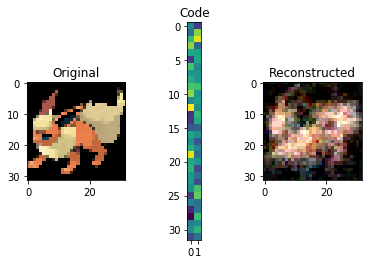

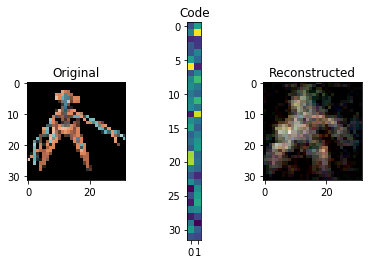

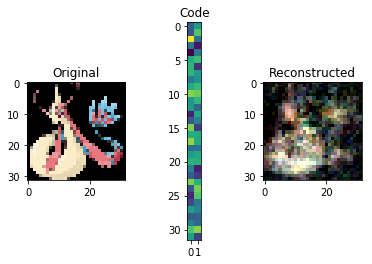

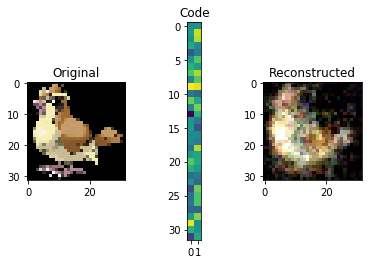

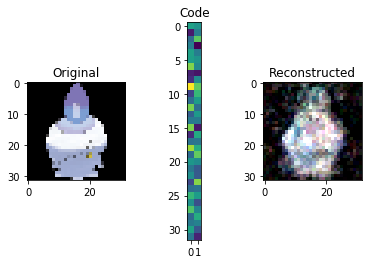

In [31]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

Not looking good for our autoencoder. The shape seems to be right but its just a heavily blurred.
We can still improve this model by making use of properties that images have, to that we need to go deeper.

![deeper](http://www.quickmeme.com/img/e7/e7633bedf897bb24ce668ac9c5df6bf88a58ff7e114d27606a756f4c4888a3f1.jpg)

## Convolutional layers

Using convolutional layers we can make use of some peculiarities of images. Like patches that are close to each other have a higher relation and this patch being transladed does not change its relation. 

The convolutions make the trained features resistant to translation what can help us identify high level features like eyes, in case of facial images.

For the decoder part of the model, we will make use of the convolutional layer's upside-down brother, the Transposed Convolution. Instead of translation a patch of image into a single number, this operation translates a single number into a patch. We stack several of these layers to reconstruct the original image.

In [20]:
def covolutional_autoencoder(img_shape, code_size):

    # encoder
    encoder = keras.models.Sequential()
    encoder.add(Layers.InputLayer(img_shape))
    encoder.add(Layers.Conv2D(64,(3,3),activation='elu', padding='same', input_shape=img_shape))
    encoder.add(Layers.Dropout(0.2))
    encoder.add(Layers.Conv2D(256,(3,3),activation='elu', padding='same'))
    encoder.add(Layers.Dropout(0.2))
    encoder.add(Layers.Flatten())
    encoder.add(Layers.Dense(512))
    encoder.add(Layers.Dropout(0.2))
    encoder.add(Layers.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(Layers.InputLayer((code_size,)))
    decoder.add(Layers.Dense(code_size))
    decoder.add(Layers.Dense(32*32*256))
    encoder.add(Layers.Dropout(0.2))
    decoder.add(Layers.Reshape(target_shape=(32,32,256)))
    decoder.add(Layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(Layers.Dropout(0.2))
    decoder.add(Layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='elu', padding='same'))
    
    
    return encoder, decoder

Lets also train it for longer

In [21]:
sess = reset_tf_session() #reseting the session, just in case
encoder,decoder = covolutional_autoencoder(IMG_SIZE, code_size=64)

input_l = Layers.Input(IMG_SIZE)
code = encoder(input_l)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=input_l, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=30,
                validation_data=[X_test, X_test],
                callbacks=[TqdmProgressCallback()],
                verbose=0)

Epoch 1/30


A Jupyter Widget

Epoch 2/30


A Jupyter Widget

Epoch 3/30


A Jupyter Widget

Epoch 4/30


A Jupyter Widget

Epoch 5/30


A Jupyter Widget

Epoch 6/30


A Jupyter Widget

Epoch 7/30


A Jupyter Widget

Epoch 8/30


A Jupyter Widget

Epoch 9/30


A Jupyter Widget

Epoch 10/30


A Jupyter Widget

Epoch 11/30


A Jupyter Widget

Epoch 12/30


A Jupyter Widget

Epoch 13/30


A Jupyter Widget

Epoch 14/30


A Jupyter Widget

Epoch 15/30


A Jupyter Widget

Epoch 16/30


A Jupyter Widget

Epoch 17/30


A Jupyter Widget

Epoch 18/30


A Jupyter Widget

Epoch 19/30


A Jupyter Widget

Epoch 20/30


A Jupyter Widget

Epoch 21/30


A Jupyter Widget

Epoch 22/30


A Jupyter Widget

Epoch 23/30


A Jupyter Widget

Epoch 24/30


A Jupyter Widget

Epoch 25/30


A Jupyter Widget

Epoch 26/30


A Jupyter Widget

Epoch 27/30


A Jupyter Widget

Epoch 28/30


A Jupyter Widget

Epoch 29/30


A Jupyter Widget

Epoch 30/30


A Jupyter Widget

PCA MSE: 0.610598212335


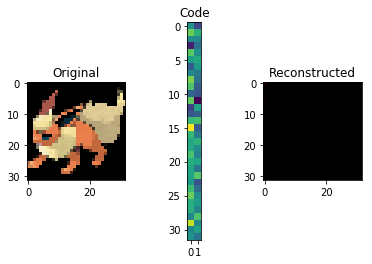

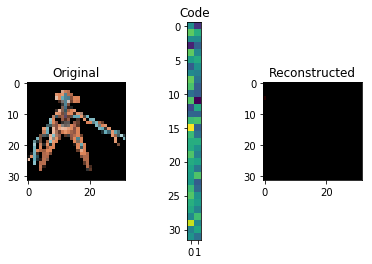

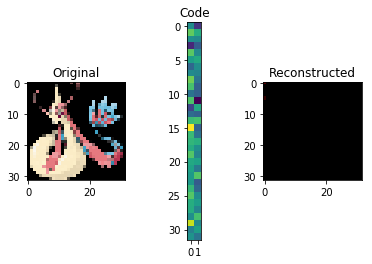

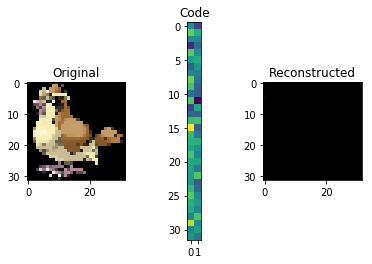

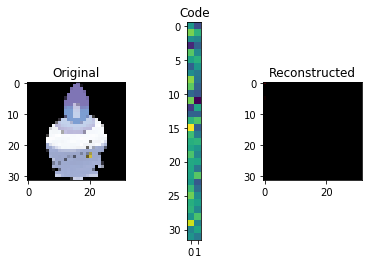

In [22]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)